In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):

    messages:Annotated[list, add_messages]


In [3]:
import os 
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv('GROQ_API_KEY')

In [4]:
from langchain_groq import ChatGroq
model_name='llama-3.1-8b-instant'
llm=ChatGroq(model=model_name, api_key=api_key)

In [5]:
# Node Functionality
def chatbot(state:State):
    return {'messages':[llm.invoke(state['messages'])]}

In [6]:
graph_builder = StateGraph(State)

# adding Node
graph_builder.add_node('chatbot',chatbot)

# Adding Edges
graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

# compile graph
graph = graph_builder.compile()

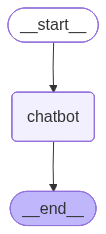

In [7]:
graph

In [8]:
response = graph.invoke({"messages":"Hello"})

In [9]:
response["messages"][-1].content

'How can I assist you today?'

In [10]:
for event in graph.stream({"messages":"Hi how are you?"}):
    print(event)

{'chatbot': {'messages': [AIMessage(content="I'm functioning properly. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 40, 'total_tokens': 53, 'completion_time': 0.01964048, 'prompt_time': 0.001962201, 'queue_time': 0.187629554, 'total_time': 0.021602681}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_90c2e79dab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9e6d358c-faf5-4e76-9895-de2e009d77c3-0', usage_metadata={'input_tokens': 40, 'output_tokens': 13, 'total_tokens': 53})]}}


# Chatbot with Tool

In [11]:
from langchain_tavily import TavilySearch

tavily_api_key = os.getenv("TAVILY_API_KEY")
tool = TavilySearch(max_results=2, api_key=tavily_api_key)

In [12]:
tool.invoke("Who is CEO of Charter Communications?")

{'query': 'Who is CEO of Charter Communications?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://craft.co/charter-communications/executives',
   'title': 'Charter Communications CEO and Key Executive Team - Craft.co',
   'content': "Charter Communications Charter Communications # Charter Communications CEO and Key Executive Team Charter Communications's President and Chief Executive Officer is Christopher Winfrey. Charter Communications's key executives include Christopher Winfrey and 33 others. * T-Mobile Mobile & Telecommunications\xa0- Public Mobile & Telecommunications\xa0- Public Mobile & Telecommunications\xa0- Public * Verizon Communications Mobile & Telecommunications\xa0- Public Craft can deliver 250+ data points of financial, operating, and human capital indicators on companies via API. * Intelligence Suite * Supplier Intelligence Platform * Craft Intelligence Portal * Craft API * Craft for Teams * Supplier Intelligence Platform *

In [14]:
# custom function

def multiply(a:int, b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Rreturns:
        int: output int
    """
    return a*b


In [15]:
tools = [tool,multiply]

In [16]:
llm_with_tool = llm.bind_tools(tools)

In [17]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x1101517f0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x1101523c0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domai

In [28]:
# Stategraph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

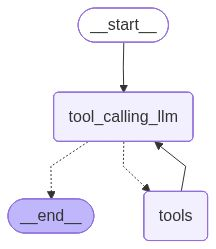

In [20]:
# Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

# Add Edges
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", 'tool_calling_llm')

# Compile
graph = builder.compile(checkpointer=memory)

graph

In [21]:
response['messages'][-1].content

'How can I assist you today?'

In [22]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

How can I assist you today?


In [133]:
config={"configurable":{"thread_id":"1"}}

response = graph.invoke({'messages':"Hey do you remember me?"}, config=config)

In [126]:
response

{'messages': [HumanMessage(content='Hi my name is Abhijit!', additional_kwargs={}, response_metadata={}, id='b3942981-904e-4b4e-9acf-8983981b055e'),
  AIMessage(content="Hello Abhijit. It's nice to meet you. Is there anything I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 1858, 'total_tokens': 1887, 'completion_time': 0.029533188, 'prompt_time': 0.115643023, 'queue_time': 0.19450362, 'total_time': 0.145176211}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2115512ff6', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--42ae340b-5999-4244-8b52-c0ccf1680855-0', usage_metadata={'input_tokens': 1858, 'output_tokens': 29, 'total_tokens': 1887})]}